In [52]:
import pandas as pd
import numpy as np
from collections import Counter
import os
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt

# Data

In [3]:
# my_followers_df has been uploaded to Google Drive
followers = pd.read_csv('/Users/marzie/Documents/Data/my_followers_df')
followers

,user_id,podcaster_id
0,1022618,13480902
1,1022618,19399631
2,1022618,15572542
3,1022618,18150210
4,1022618,17363840
...,...,...
18578845,39261848,12347707
18578846,39261848,21673341
18578847,39261848,24438995
18578848,39261848,19624777


### drop users who follow fewer than 10 podcasts. 

In [4]:
sub_num_min = 10 

In [5]:
# Finding out how many podcasts each user follows.

follower_df_user_id_s = followers['user_id'].tolist()

user_sub = dict(Counter(follower_df_user_id_s))

following_df = pd.DataFrame(
    data=list(user_sub.items()),
    columns=['user_id', 'following']).set_index('user_id')

following_df.head()

,following
user_id,
1022618,203
1032649,28
1038639,99
1049063,57
1049719,35


In [6]:
# drop users who follow fewer than 10 podcasts.

updated_users = following_df[following_df['following'] > sub_num_min].index.values

print(updated_users)
print()
print(len(updated_users))

[ 1022618  1032649  1038639 ... 39247460 39261381 39261848]

479210


### Split users into train and test.

The cell below was run once, and then we used the saved result.

In [7]:
# # Splitting updated_users into random train and test subsets.
# # %80 train and %20 test.

# np.random.shuffle(updated_users)

# train_user_ids = updated_users[:int(len(updated_users)*0.8)]
# test_user_ids = updated_users[int(len(updated_users)*0.8):]

# #save train and test user_ids
# np.save("train_user_ids", train_user_ids)
# np.save("test_user_ids", test_user_ids)

In [109]:
train_user_ids = np.load("train_user_ids.npy")
test_user_ids = np.load("test_user_ids.npy")

### Constructing the co-following matrix based on train users.

In [40]:
df = followers[followers['user_id'].isin(train_user_ids)]

In [10]:
matrix_rows = df['podcaster_id'].unique()

matrix_columns = df['user_id'].unique()

In [11]:
# Constructing the user-podcast Biadjacency Matrix

matrix = np.zeros((len(matrix_rows), len(matrix_columns)), dtype=bool)

for i in tqdm(range(len(matrix_rows))):
    
    mask = (df['podcaster_id'] == matrix_rows[i])
    
    index = np.where(np.in1d(matrix_columns, np.array(df[mask]['user_id'])))[0]
    
    matrix[i][index] = True

100%|██████████████████████████████████████| 3232/3232 [00:26<00:00, 123.22it/s]


In [12]:
# Constructing common_followers Matrix

number_of_podcasters = len(matrix_rows)

common_followers = np.zeros((number_of_podcasters, number_of_podcasters))

for i in tqdm(range(number_of_podcasters)):
    for j in range(i+1, number_of_podcasters):
        
        common_followers[i, j] = (matrix[i]*matrix[j]).sum()

100%|███████████████████████████████████████| 3232/3232 [22:57<00:00,  2.35it/s]


In [13]:
n = len(common_followers)

i_lower = np.tril_indices(n, -1)

common_followers[i_lower] = common_followers.T[i_lower] 

In [18]:
# Finding the five nearest neighbors based on the common followers of each podcast.
five_nearest_neigh = np.argsort(-common_followers)[:, :5]

### Finding the five nearest podcasts for each user.

In [46]:
# Finding the five nearest podcasts for each user.

df1 = followers[followers['user_id'].isin(updated_users)]

def five_nearest_podcasts(user_id):
    
    podcaster_id_s = df1[df1['user_id'] == user_id]['podcaster_id'].tolist()
    
    index = np.where(np.in1d(matrix_rows, podcaster_id_s))[0]
    
    temp = list(five_nearest_neigh[index].flatten())
                     
    sorted_neigh = [key for key, value in Counter(temp).most_common()]
    
    return sorted_neigh[:5]

In [47]:
%%time
df2 = pd.DataFrame(np.unique(updated_users), columns=['user_id'])

result_df = df2['user_id'].apply(lambda x: pd.Series(five_nearest_podcasts(x)))

result_df.columns = ['nei1', 'nei2', 'nei3', 'nei4', 'nei5']

nearest_neigh_df = pd.concat([df2, result_df], axis=1)

nearest_neigh_df

CPU times: user 2h 4min 30s, sys: 1min 36s, total: 2h 6min 7s
Wall time: 31min 57s


,user_id,nei1,nei2,nei3,nei4,nei5
0,1022618,135,145,48,158,202
1,1032649,135,29,145,48,71
2,1038639,135,48,145,202,158
3,1049063,135,29,145,71,48
4,1049719,135,29,145,24,71
...,...,...,...,...,...,...
479205,39245056,135,48,202,145,158
479206,39246777,135,145,158,118,97
479207,39247460,135,145,48,158,202
479208,39261381,135,158,145,48,29


### Creating a DataFrame that contains categories and the nearest podcasts related to each user.

In [117]:
# user_categories_df has been uploaded to Google Drive
category_df = pd.read_csv('/Users/marzie/Documents/Data/user_categories_df')

In [118]:
final_df = pd.merge(nearest_neigh_df, category_df, on='user_id', how='inner')
final_df.set_index('user_id', inplace=True)
final_df

,nei1,nei2,nei3,nei4,nei5,category1,category2,category3,category4,category5
user_id,,,,,,,,,,
1022618,135,145,48,158,202,10101.0,10058.0,10022.0,10002.0,10028.0
1032649,135,29,145,48,71,10101.0,10091.0,10012.0,10043.0,10104.0
1038639,135,48,145,202,158,10101.0,10002.0,10028.0,10022.0,10043.0
1049063,135,29,145,71,48,10101.0,10002.0,10028.0,10009.0,10071.0
1049719,135,29,145,24,71,10101.0,10009.0,10071.0,10022.0,10103.0
...,...,...,...,...,...,...,...,...,...,...
39245056,135,48,202,145,158,10101.0,10022.0,10058.0,10059.0,10044.0
39246777,135,145,158,118,97,10101.0,10058.0,10124.0,10102.0,10044.0
39247460,135,145,48,158,202,10071.0,10009.0,10107.0,10013.0,10043.0


###  basic statistical analysis
plotting a histogram for each of the columns in the above DataFrame

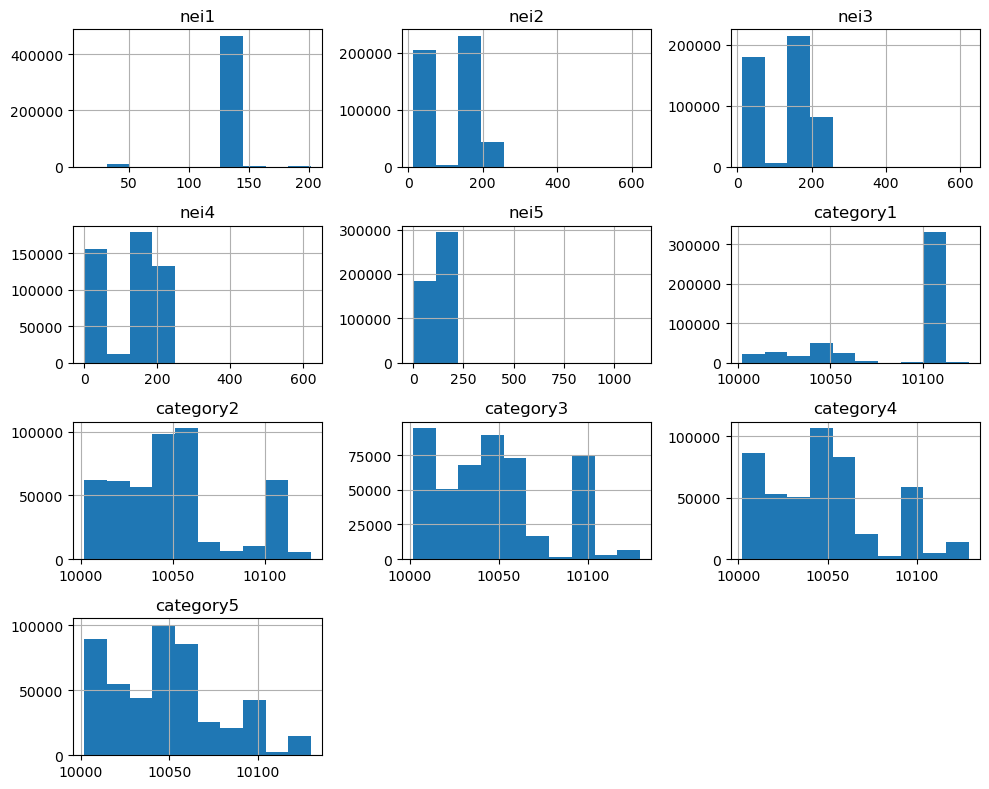

In [119]:
final_df.hist(figsize=(10, 8))
plt.tight_layout()  # Adjust layout to prevent overlap of axes labels
plt.show()

Considering the histograms above, we will remove two columns, 'nei1' and 'category1'

In [120]:
final_df = final_df.drop(['nei1', 'category1'], axis=1)
final_df

,nei2,nei3,nei4,nei5,category2,category3,category4,category5
user_id,,,,,,,,
1022618,145,48,158,202,10058.0,10022.0,10002.0,10028.0
1032649,29,145,48,71,10091.0,10012.0,10043.0,10104.0
1038639,48,145,202,158,10002.0,10028.0,10022.0,10043.0
1049063,29,145,71,48,10002.0,10028.0,10009.0,10071.0
1049719,29,145,24,71,10009.0,10071.0,10022.0,10103.0
...,...,...,...,...,...,...,...,...
39245056,48,202,145,158,10022.0,10058.0,10059.0,10044.0
39246777,145,158,118,97,10058.0,10124.0,10102.0,10044.0
39247460,145,48,158,202,10009.0,10107.0,10013.0,10043.0


In [134]:
train_users_df = final_df.loc[final_df.index.isin(np.unique(train_user_ids))]
train_users_df.to_csv('train_users_df.csv')
train_users_df

,nei2,nei3,nei4,nei5,category2,category3,category4,category5
user_id,,,,,,,,
1022618,145,48,158,202,10058.0,10022.0,10002.0,10028.0
1032649,29,145,48,71,10091.0,10012.0,10043.0,10104.0
1038639,48,145,202,158,10002.0,10028.0,10022.0,10043.0
1049063,29,145,71,48,10002.0,10028.0,10009.0,10071.0
1056785,48,145,202,158,10043.0,10059.0,10063.0,10022.0
...,...,...,...,...,...,...,...,...
39241602,145,118,158,97,10058.0,10124.0,10044.0,10102.0
39242183,48,145,202,158,10058.0,10044.0,10009.0,10071.0
39246777,145,158,118,97,10058.0,10124.0,10102.0,10044.0


In [130]:
test_users_df = final_df.loc[final_df.index.isin(np.unique(test_user_ids))]
test_users_df.to_csv('test_users_df.csv')

### feature_selection

The features we selected for our problem consist of four frequently followed categories by a user and four podcasts that, based on the podcast network constructed according to common followers, are close to the podcasts followed by the user. 

We represented both of them numerically, meaning we assigned a number to each podcast and category. The numbers assigned to podcasts range from 0 to 3231, and the numbers assigned to categories are the same as those present in the castbox.

The last feature is the "j-th" podcast, and finally, we defined the label in such a way that if user "i" follows podcast "j", y = 1, otherwise y = 0.

### random sampling
Given the defined X and y, we randomly sample 10^6 samples from this dataset.

In [136]:
sample_user = np.random.randint(0, len(train_user_ids), 10**6)
sampel_podcasts = np.random.randint(0, len(matrix), 10**6)
# np.save("sampel_podcasts", sampel_podcasts)
# np.save("sample_user", sample_user)

In [137]:
sample_user = np.load("sample_user.npy")
sampel_podcasts = np.load("sampel_podcasts.npy")

In [148]:
user_data = train_users_df.to_numpy()

In [144]:
X_y_data = np.zeros((10**6, 10))

X_y_data[:, :8] = user_data[sample_user]

X_y_data[:, 8] = sampel_podcasts

delta_ij = matrix[sampel_podcasts, sample_user].astype(int)

X_y_data[:, 9] = delta_ij

In [145]:
X_y_data

array([[  145.,    48.,   202., ..., 10043.,  2401.,     0.],
       [   48.,   202.,   145., ..., 10059.,   120.,     0.],
       [  145.,   158.,    48., ..., 10012.,  1803.,     0.],
       ...,
       [  135.,   158.,    48., ..., 10058.,   227.,     0.],
       [   48.,   145.,   202., ..., 10058.,   532.,     0.],
       [  158.,   202.,   145., ..., 10044.,  1493.,     0.]])

In [149]:
np.save("X_y_data", X_y_data)